# Explore here

## Step 1: Problem statement and data collection

Problem statement: given sociodemographic and health resource data have been collected by county in the United States, find out if there is any relationship between health resources and sociodemographic data

In [2]:
# Import dataset to start working with it
import pandas as pd

raw_data = pd.read_csv("../data/raw/demographic_health_data.csv", sep=",")

## Step 2: Exploration and data cleaning

In [3]:
print(f"Raw data shape: {raw_data.shape}")
print(raw_data.info(show_counts=True))

#.info won't make it so easy to find nulls now that we're looking at larger datasets, so let's try other methods...
missing_summary = (
    raw_data.isna().sum()                         # raw counts
      .to_frame('null_count')
      .assign(null_pct=lambda s: s['null_count'].div(len(raw_data))*100)
      .query('null_count > 0')              # keep only problem columns
      .sort_values('null_pct', ascending=False)
)

missing_summary.head(10).style.bar('null_pct')

Raw data shape: (3140, 108)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3140 entries, 0 to 3139
Columns: 108 entries, fips to Urban_rural_code
dtypes: float64(61), int64(45), object(2)
memory usage: 2.6+ MB
None


,null_count,null_pct


Doesn't look as though any of our columns have missing data at all, which simplifies matters.

I'm going to make the simplified assumption that any rows which have identical values across all columns are duplicates of the same county, rather than being actually-distinct counties with so-similar statistics.
I'm also going to make the assumption that FIPS codes are unique by county, and once a first instance is found of a row with a FIPS code, subsequent rows using the same code are to be treated as duped or invalid data. 

In [4]:
raw_data.drop_duplicates(inplace=True)
raw_data = raw_data.drop_duplicates(subset=["fips"], keep="first", ignore_index=True)


print(raw_data.shape)
raw_data.head()
raw_data.info()

(3140, 108)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3140 entries, 0 to 3139
Columns: 108 entries, fips to Urban_rural_code
dtypes: float64(61), int64(45), object(2)
memory usage: 2.6+ MB


### Removing irrelevant data:

- Based on discussion with professor, my instinct is correct that FIPS codes in this context operate as categorical rather than numerical variables.  With only 3000 rows, that's not likely enough data to effectively train the model at so-granular a level as county; sounds like we'd be better off going coarser grouping by state-level fips code instead.

In [5]:
# remove data considered irrelevant
raw_data.drop(
   ["fips"],
   axis=1,
   inplace=True,
)


raw_data.head()

,TOT_POP,0-9,0-9 y/o % of total pop,19-Oct,10-19 y/o % of total pop,20-29,20-29 y/o % of total pop,30-39,30-39 y/o % of total pop,40-49,...,COPD_number,diabetes_prevalence,diabetes_Lower 95% CI,diabetes_Upper 95% CI,diabetes_number,CKD_prevalence,CKD_Lower 95% CI,CKD_Upper 95% CI,CKD_number,Urban_rural_code
0,55601,6787,12.206615,7637,13.735364,6878,12.370281,7089,12.749771,7582,...,3644,12.9,11.9,13.8,5462,3.1,2.9,3.3,1326,3
1,218022,24757,11.355276,26913,12.344167,23579,10.814964,25213,11.564429,27338,...,14692,12.0,11.0,13.1,20520,3.2,3.0,3.5,5479,4
2,24881,2732,10.980266,2960,11.896628,3268,13.134520,3201,12.865239,3074,...,2373,19.7,18.6,20.6,3870,4.5,4.2,4.8,887,6
3,22400,2456,10.964286,2596,11.589286,3029,13.522321,3113,13.897321,3038,...,1789,14.1,13.2,14.9,2511,3.3,3.1,3.6,595,2
4,57840,7095,12.266598,7570,13.087828,6742,11.656293,6884,11.901798,7474,...,4661,13.5,12.6,14.5,6017,3.4,3.2,3.7,1507,2


## Step 3: Analysis of univariate variables
### categorical variables
Categorical, non-numeric variables in this dataframe include: county-level fips (which we just deleted), STATE_FIPS, and Urban_rural_code

In [6]:
categorical_variables = [
    "STATE_FIPS",
    "Urban_rural_code",
]

for each_categorical_variable in categorical_variables:
    print(f"\n\t{each_categorical_variable}s:")
    for each_possible_value in sorted(
        raw_data[f"{each_categorical_variable}"].unique()
    ):
        print(each_possible_value)


	STATE_FIPSs:
1
2
4
5
6
8
9
10
11
12
13
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
44
45
46
47
48
49
50
51
53
54
55
56

	Urban_rural_codes:
1
2
3
4
5
6


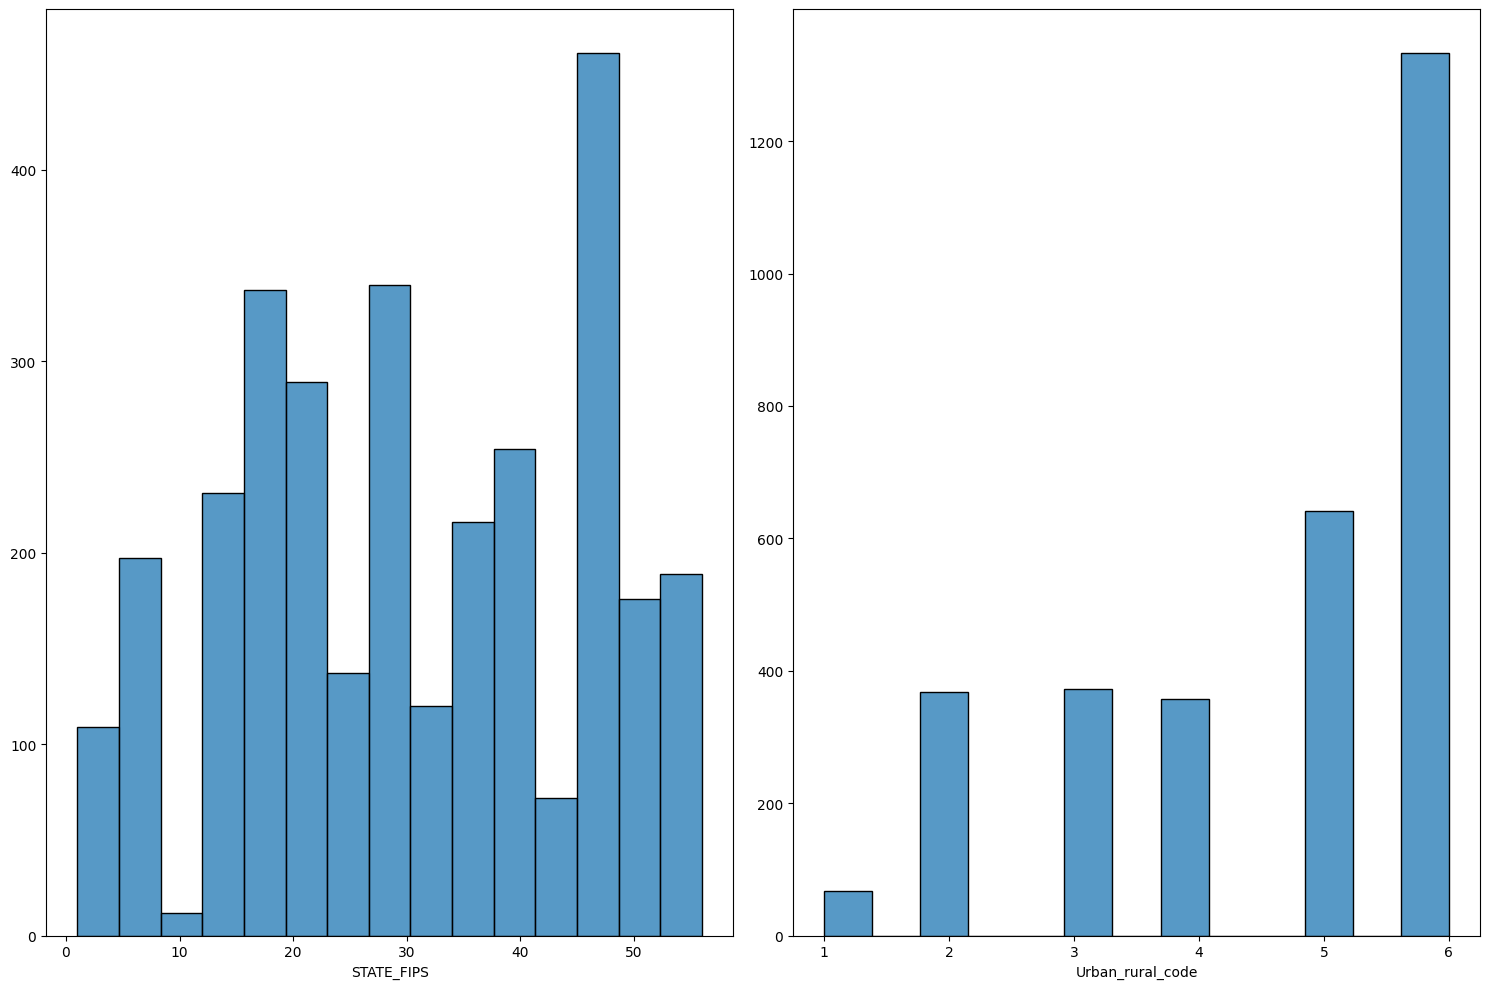

In [7]:
# histogram-plot each categorical variable

import matplotlib.pyplot as plt
import seaborn as sns

fig, axis = plt.subplots(1, 2, figsize=(15, 10))

# Create a multiple histogram
sns.histplot(ax=axis[0], data=raw_data, x="STATE_FIPS", bins="auto").set(ylabel=None)
sns.histplot(ax=axis[1], data=raw_data, x="Urban_rural_code").set(ylabel=None)

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

- many more counties worth of data available for some states than others; almost all are between 100 and 350 but the extrmes range from the tens all the way up to over 450 
- Despite data dictionary including codings above 6 we don't appear to have any instances of them in the data.
- Most counties have populations between 2,500 and 19,999 

### numeric variables

Numerical, non-categorical variables in the dataset: vast majority of them, just need to mask out a 

In [13]:
numeric_variables = raw_data.columns[~raw_data.columns.isin(["STATE_FIPS", "Urban_rural_code"])] 
print(numeric_variables)

Index(['TOT_POP', '0-9', '0-9 y/o % of total pop', '19-Oct',
       '10-19 y/o % of total pop', '20-29', '20-29 y/o % of total pop',
       '30-39', '30-39 y/o % of total pop', '40-49',
       ...
       'COPD_Upper 95% CI', 'COPD_number', 'diabetes_prevalence',
       'diabetes_Lower 95% CI', 'diabetes_Upper 95% CI', 'diabetes_number',
       'CKD_prevalence', 'CKD_Lower 95% CI', 'CKD_Upper 95% CI', 'CKD_number'],
      dtype='object', length=105)


In [ ]:
fig, axis = plt.subplots(
    2, len(numeric_variables), figsize=(30, 10), gridspec_kw={"height_ratios": [6, 1]}
)

# Creating a multiple figure with histograms and box plots
temp_column_index = 0
for each_numeric_variable in numeric_variables:
    sns.histplot(
        ax=axis[0, temp_column_index], data=raw_data, x=f"{each_numeric_variable}"
    ).set(xlabel=None, ylabel=None)
    sns.boxplot(
        ax=axis[1, temp_column_index], data=raw_data, x=f"{each_numeric_variable}"
    )
    temp_column_index += 1

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

From this it looks like:
- most people were contacted only one or few times in prior campaign, but some outliers look like they were pestered as many as 10, 20, 40 times or more
- Most contacts got off the phone within a few hundred seconds, but a much lesser quantity of calls could last a quarter-hour, half hour, or over an hour. (Will be intresting to see how that corresponds to them having taken out a long-term account).

## Step 4: Analysis of multivariate variables
### Numerical-numerical analysis
Am curious to see whether/how there are correlations between age & how long people stayed on the phone, or age & how many employees they have.


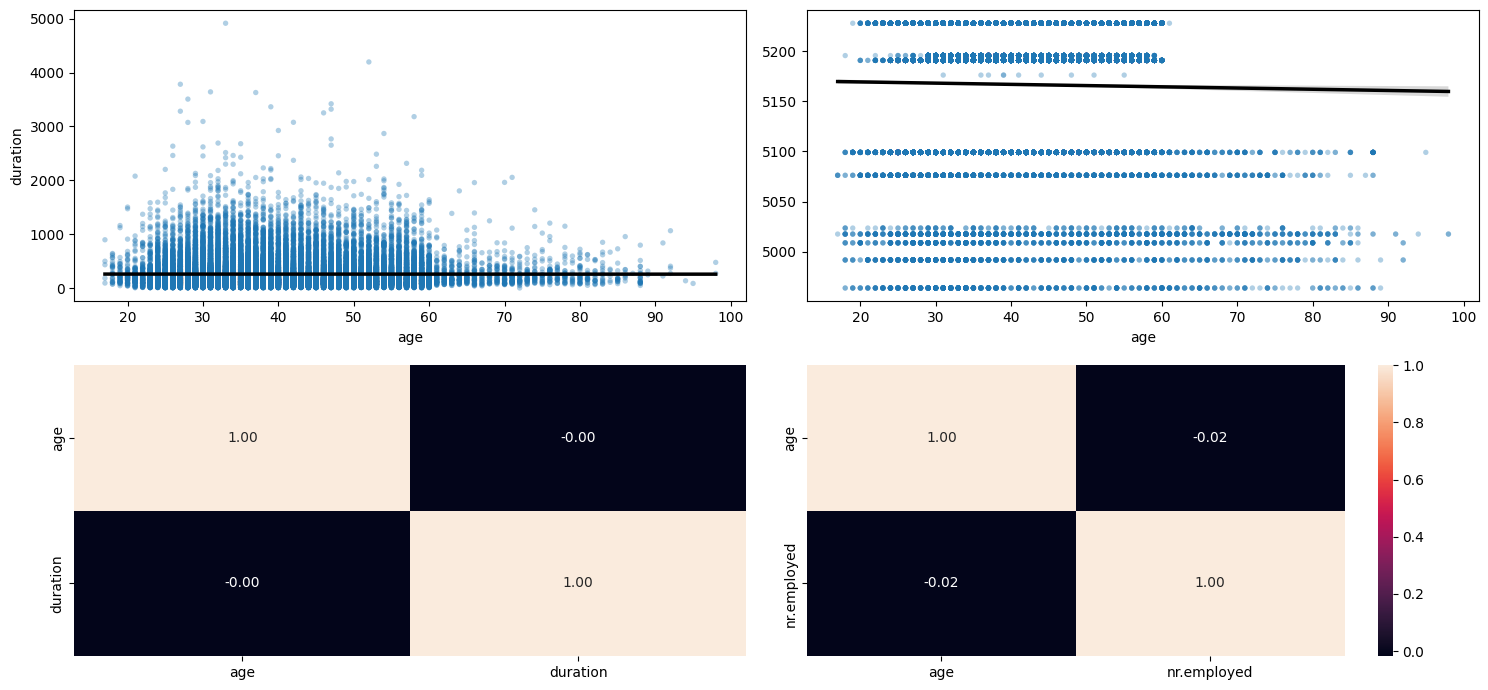

In [ ]:
fig, axis = plt.subplots(2, 2, figsize=(15, 7))

# Create a multiple scatter diagram
common_scatter = {"s": 15, "alpha": 0.35, "edgecolor": "none"}
common_line = {"color": "black", "lw": 2.5, "zorder": 5}

sns.regplot(
    ax=axis[0, 0],
    data=raw_data,
    x="age",
    y="duration",
    scatter_kws=common_scatter,
    line_kws=common_line,
)
sns.heatmap(
    raw_data[["age", "duration"]].corr(),
    annot=True,
    fmt=".2f",
    ax=axis[1, 0],
    cbar=False,
)

sns.regplot(
    ax=axis[0, 1],
    data=raw_data,
    x="age",
    y="nr.employed",
    scatter_kws=common_scatter,
    line_kws=common_line,
).set(ylabel=None)
sns.heatmap(
    raw_data[["age", "nr.employed"]].corr(),
    annot=True,
    fmt=".2f",
    ax=axis[1, 1],
)

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

Based on this it looks like there's no direct correlation between age and how long a prospect stayed on the phone.
There's a negative correlation (very slight, -0.02) whereby an older prospect has fewer employees, not more, which is opposite what I would've guessed.

### categorical-categorical analysis

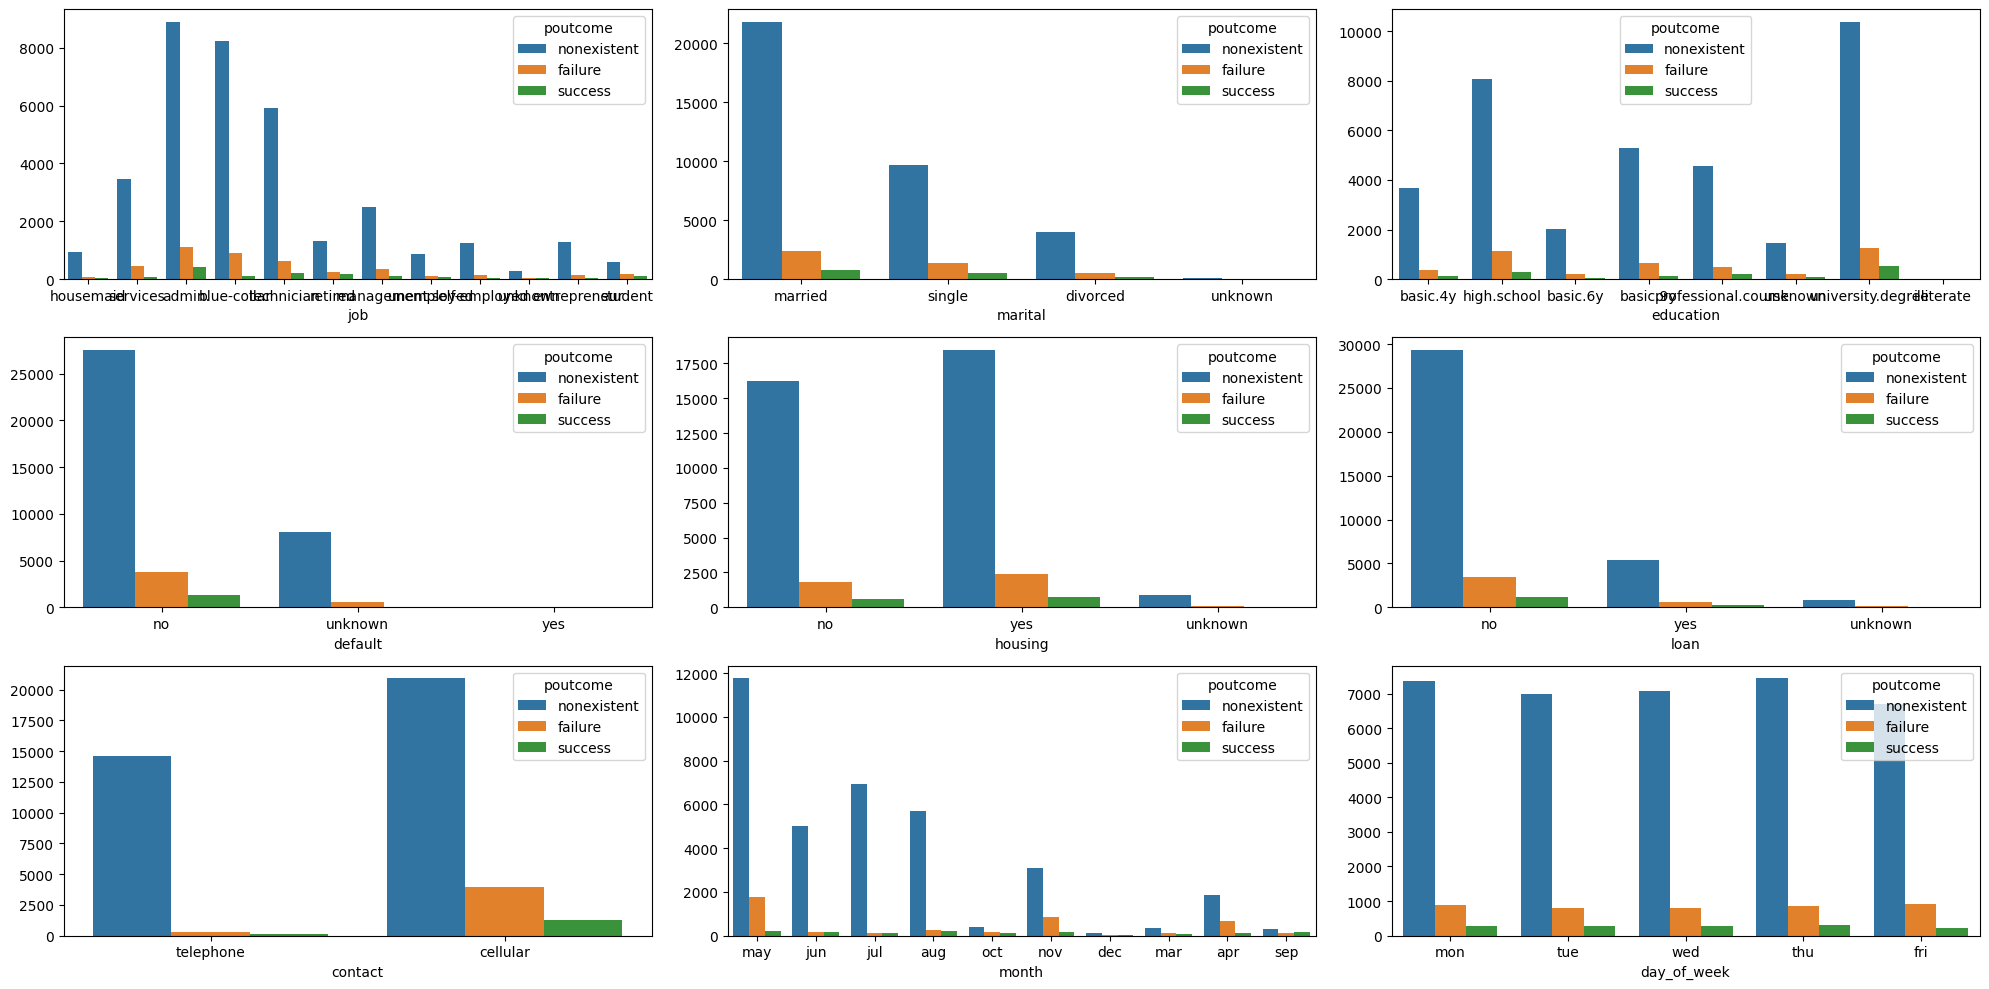

In [ ]:
temp_categorical_variables = (
    categorical_variables.copy()
)  # to avoid wrecking original copy when loop below starts popping them off the front as though a FIFO queue


fig, axis = plt.subplots(3, 3, figsize=(20, 10))



for row in range(3):


    for col in range(3):
        sns.countplot(

            ax=axis[row, col],
            data=raw_data,
            x=temp_categorical_variables[0],
            hue="poutcome",
        ).set(ylabel=None)


        temp_categorical_variables.remove(temp_categorical_variables[0])



plt.tight_layout()

plt.show()

The "nonexistent" data here is so much more prevalent than confirmed failure/success indicators for poutcome that it makes it a bit more challenging for me to assess which of these variables appears to correlate most closely with failure/success.

#### Correlation analysis


['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']


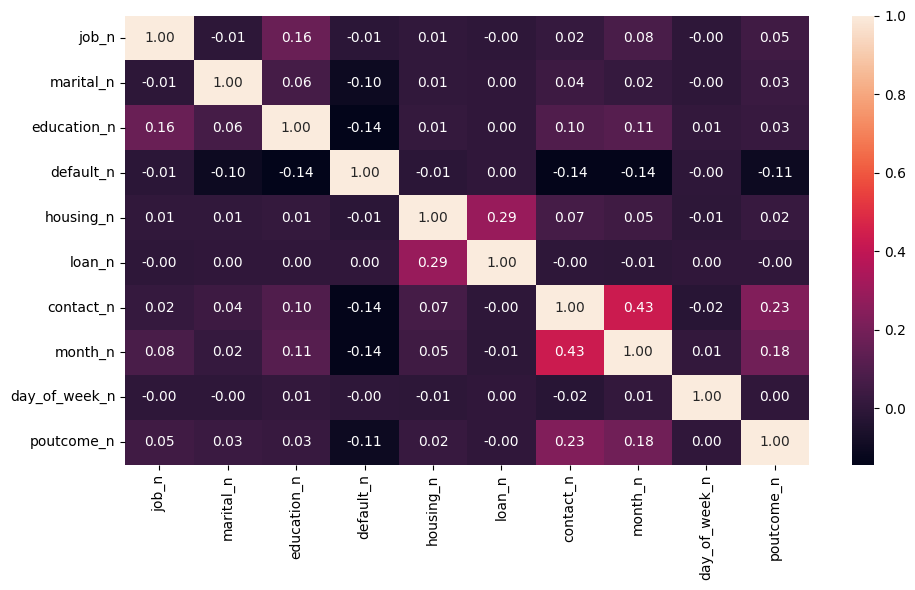

In [ ]:
print(categorical_variables)
raw_data["job_n"] = pd.factorize(raw_data["job"])[0]
raw_data["marital_n"] = pd.factorize(raw_data["marital"])[0]
raw_data["education_n"] = pd.factorize(raw_data["education"])[0]
raw_data["default_n"] = pd.factorize(raw_data["default"])[0]
raw_data["housing_n"] = pd.factorize(raw_data["housing"])[0]
raw_data["loan_n"] = pd.factorize(raw_data["loan"])[0]
raw_data["contact_n"] = pd.factorize(raw_data["contact"])[0]
raw_data["month_n"] = pd.factorize(raw_data["month"])[0]
raw_data["day_of_week_n"] = pd.factorize(raw_data["day_of_week"])[0]
raw_data["poutcome_n"] = pd.factorize(raw_data["poutcome"])[0]


fig, axis = plt.subplots(figsize=(10, 6))

sns.heatmap(
    raw_data[
        [
            "job_n",
            "marital_n",
            "education_n",
            "default_n",
            "housing_n",
            "loan_n",
            "contact_n",
            "month_n",
            "day_of_week_n",
            "poutcome_n",
        ]
    ].corr(),
    annot=True,
    fmt=".2f",
)

plt.tight_layout()

plt.show()

Based on the negative-number correlations between default_n and plenty of other variables, seems like unmarried, uneducated people are both less likely to get called and less likely to take out a long-term account.
Looks like the strongest correlation is between the type of contact and when they were last contacted (i.e. I'd expect at least one of the months to have been a major burst of a certain type of contact).
Next strongest correlation is between whether the prospect did or did not simultaneously have both a personal loan and a housing loan; if they had either, they were more likely to have both, and/or if they didn't have either, more likely to have neither.
Based on the relatively-stronger correlations of poutcome and the contact type & month, looks like it'll be worth checking what was tried during certain months to have a greater influence on outcome.

### numerical-categorical analysis

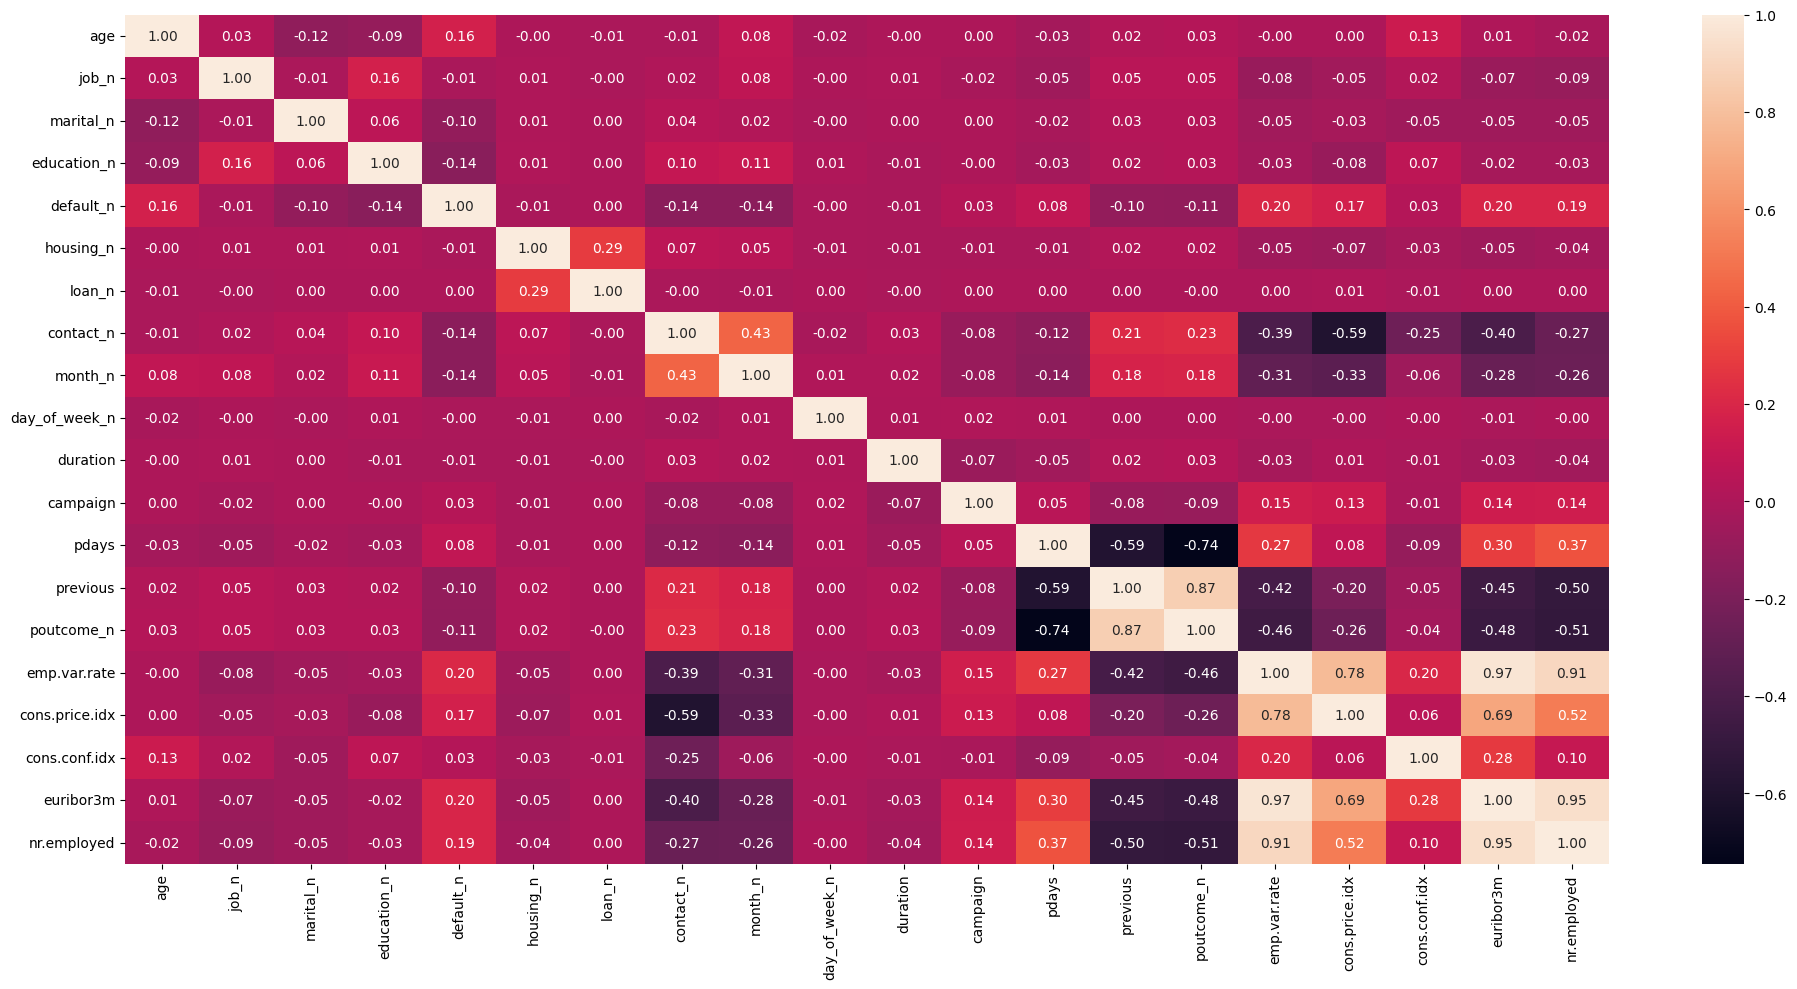

In [ ]:
fig, axis = plt.subplots(figsize=(20, 10))

sns.heatmap(
    raw_data[
        [
            "age",
            "job_n",
            "marital_n",
            "education_n",
            "default_n",
            "housing_n",
            "loan_n",
            "contact_n",
            "month_n",
            "day_of_week_n",
            "duration",
            "campaign",
            "pdays",
            "previous",
            "poutcome_n",
            "emp.var.rate",
            "cons.price.idx",
            "cons.conf.idx",
            "euribor3m",
            "nr.employed",
        ]
    ].corr(),
    annot=True,
    fmt=".2f",
)

plt.tight_layout()

plt.show()

Based on the above, I'd assess:
- the strongest indicator of outcome is "previous," i.e. how many times the prospect was contacted in a previous campaign.  The second strongest is when & how the prospect was contacted.  Most other factors have much lower or no/negligible correelation.
- There are several unsurprising correlations which aren't directly relevant to the problem we're trying to solve.  For example, consumer confidence index & price index (approximations of macroeconomic activity/health) correlate to how many people the prospect has employed.

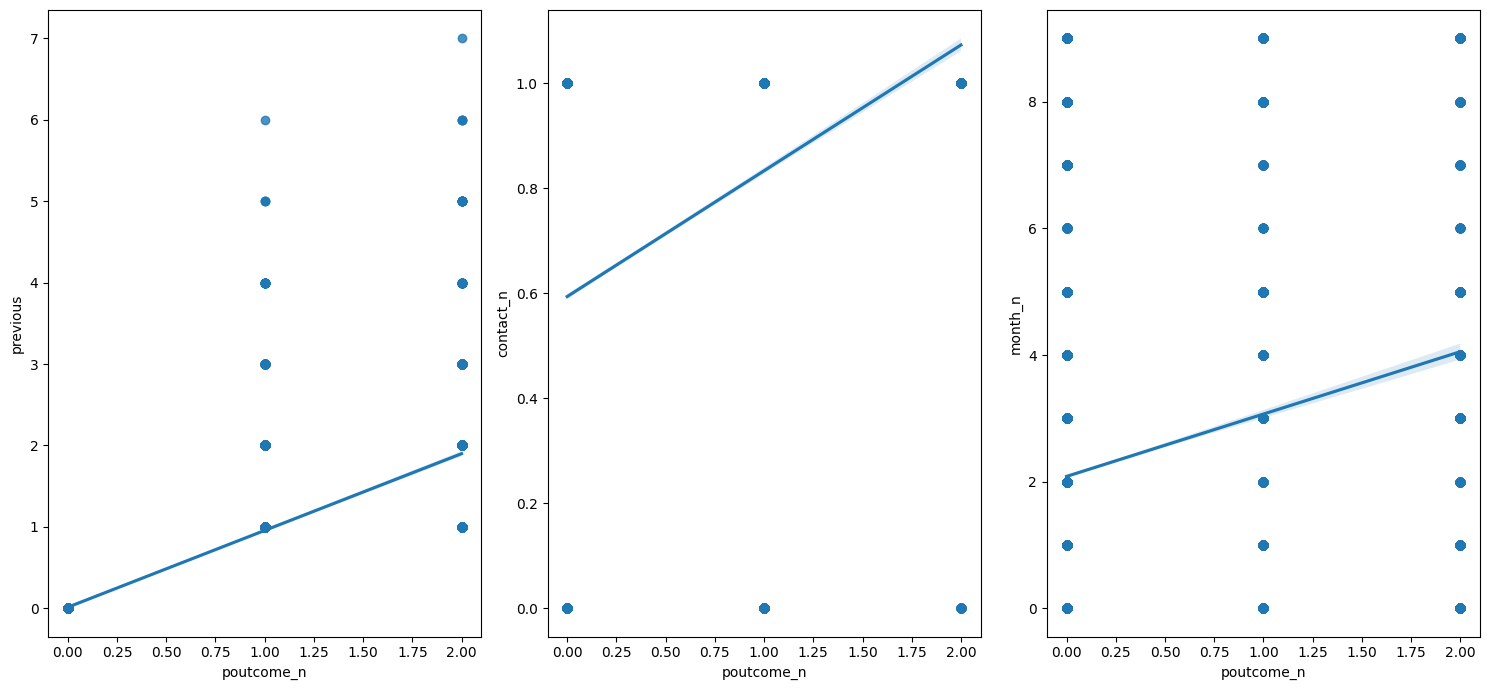

In [ ]:
fig, axis = plt.subplots(figsize=(15, 7), ncols=3)

sns.regplot(ax=axis[0], data=raw_data, x="poutcome_n", y="previous")
sns.regplot(ax=axis[1], data=raw_data, x="poutcome_n", y="contact_n")
sns.regplot(ax=axis[2], data=raw_data, x="poutcome_n", y="month_n")

plt.tight_layout()

plt.show()

Based on these regression plots:
- at first glance the visual slope for contact may make it look like the strongest-correlating variable, but the y scales differ across these plots, so actual slope of that one's shorter
- all three correlate to success/failure outcome


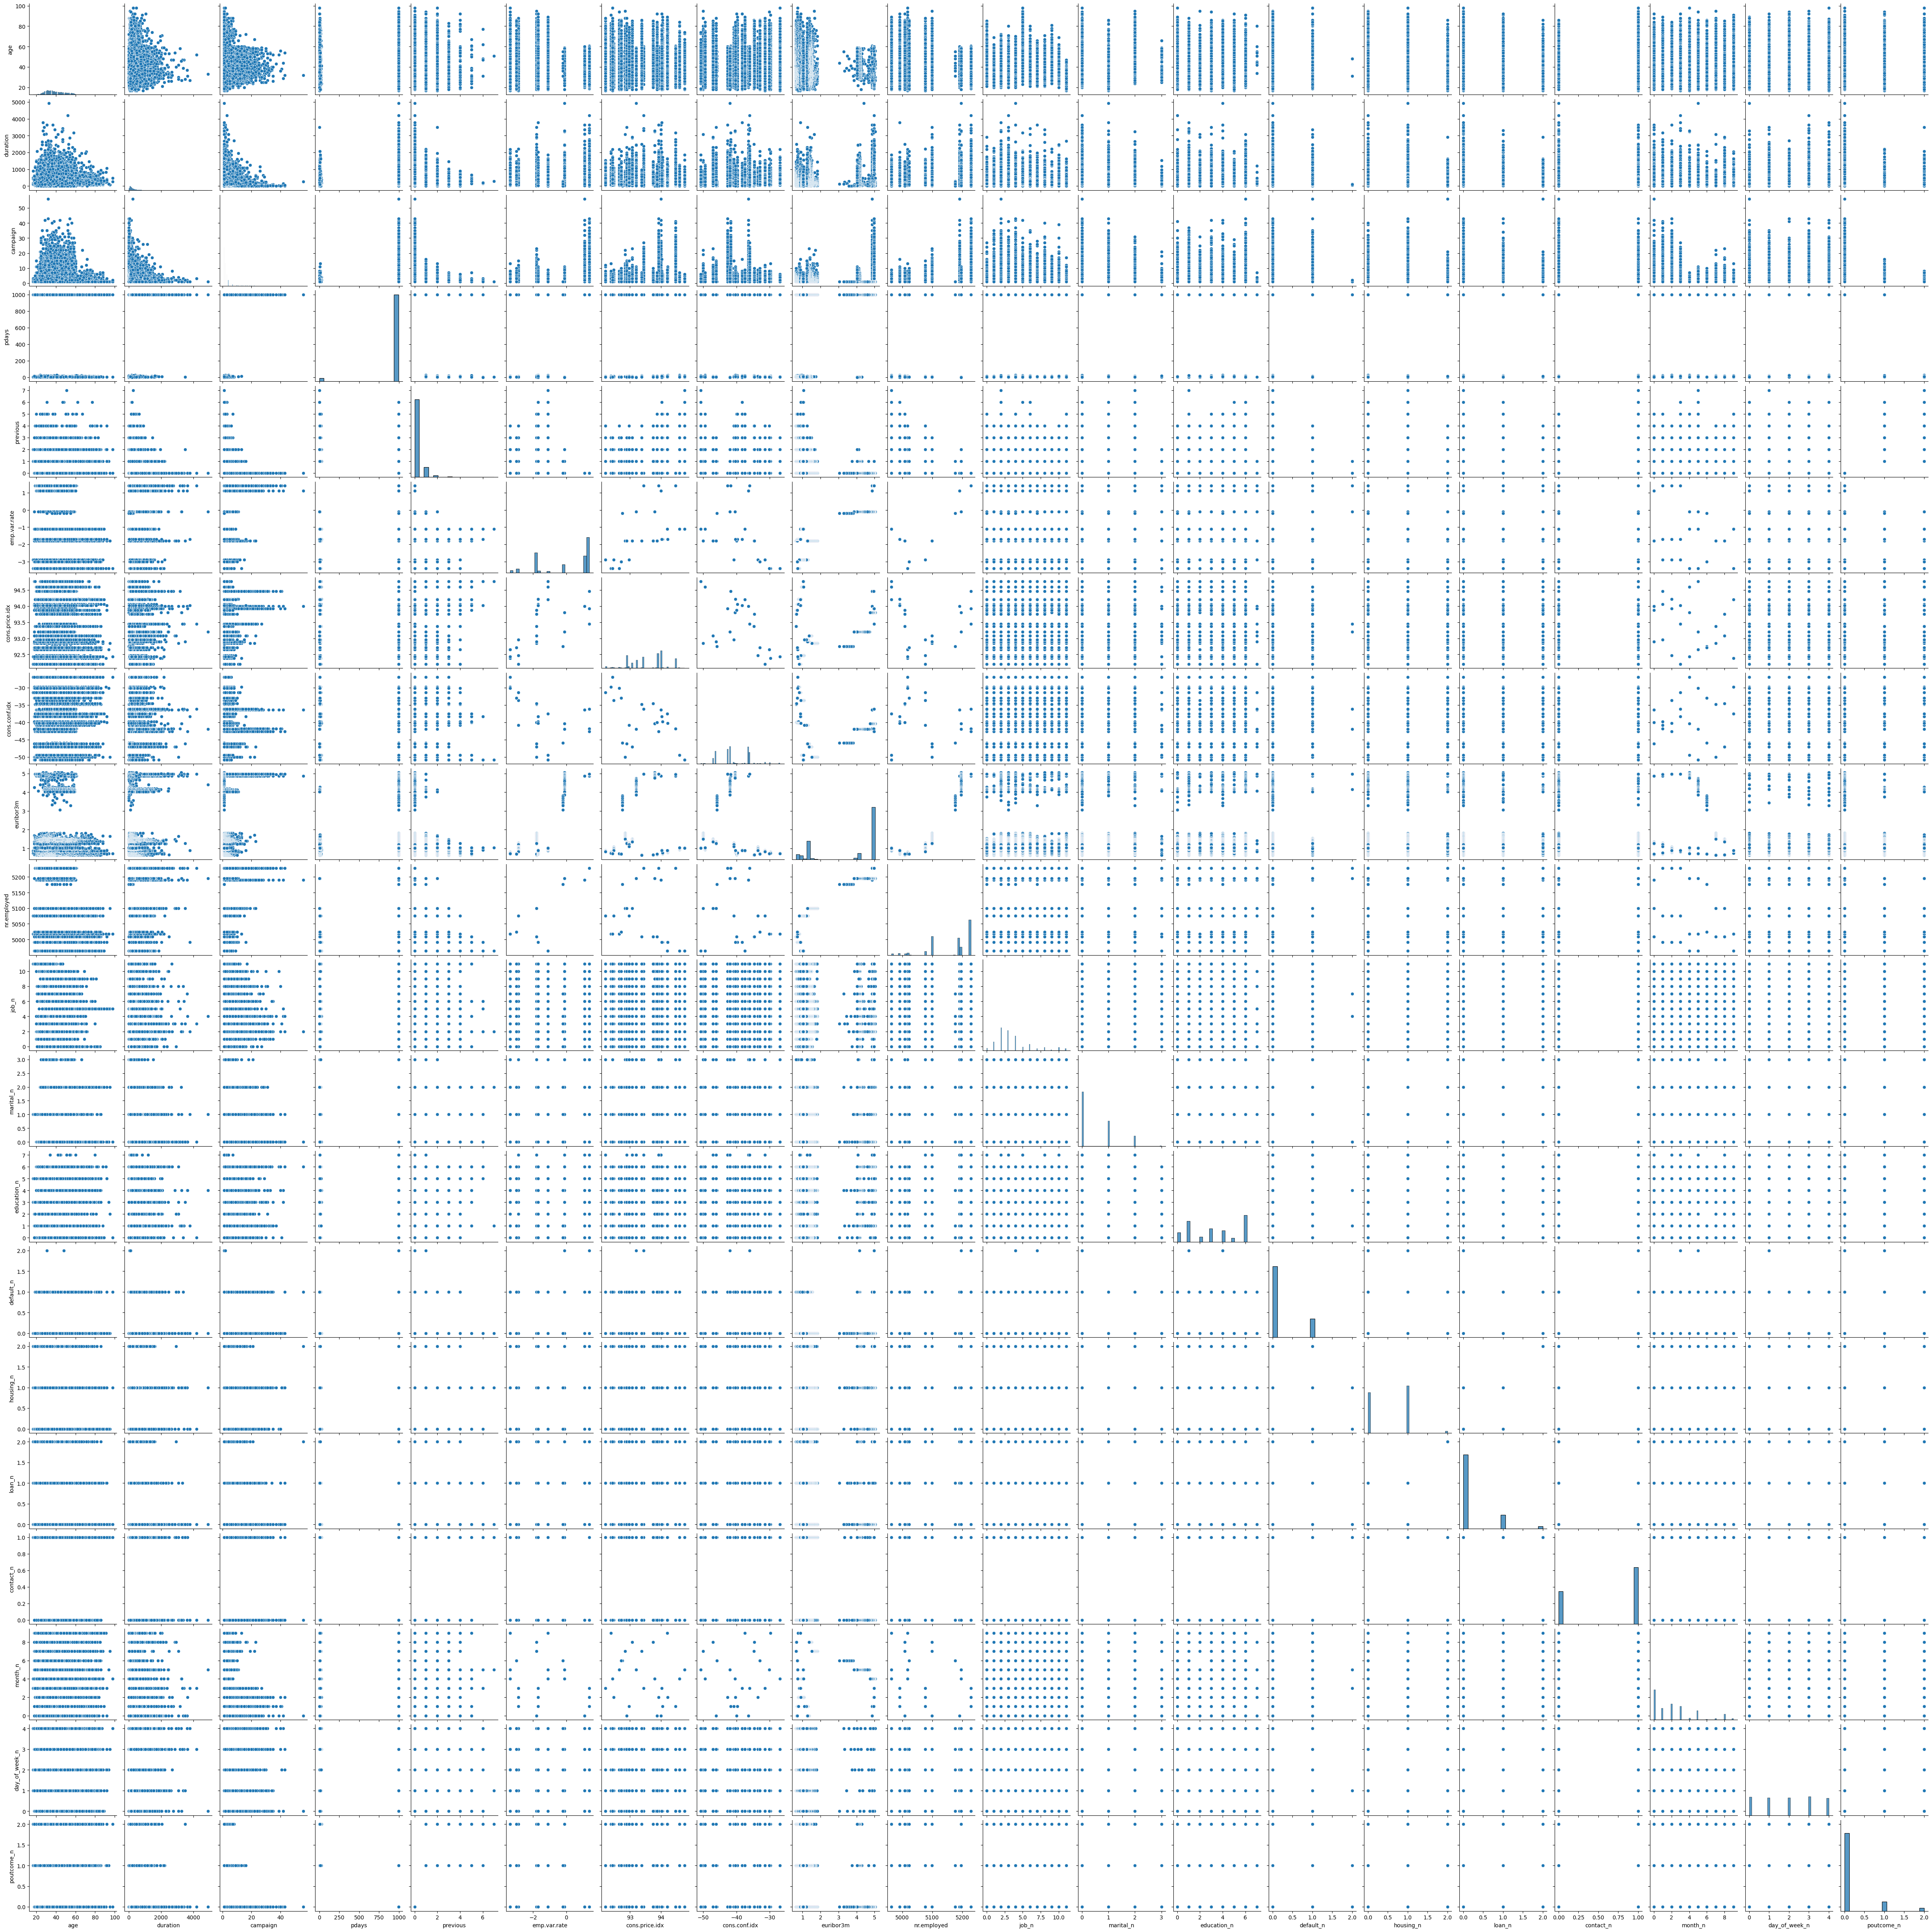

In [ ]:
sns.pairplot(data=raw_data)

In [ ]:
raw_data.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job_n,marital_n,education_n,default_n,housing_n,loan_n,contact_n,month_n,day_of_week_n,poutcome_n
count,41176.00000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000
mean,40.02380,258.315815,2.567879,962.464810,0.173013,0.081922,93.575720,-40.502863,3.621293,5167.034870,3.673863,0.510637,3.277370,0.208908,0.571959,0.199825,0.634714,2.249951,1.979600,0.169953
std,10.42068,259.305321,2.770318,186.937102,0.494964,1.570883,0.578839,4.627860,1.734437,72.251364,2.454340,0.696794,2.185558,0.406713,0.541216,0.456055,0.481516,2.429157,1.411539,0.455811
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000,2.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000,3.000000,0.000000,3.000000,0.000000,1.000000,0.000000,1.000000,2.000000,2.000000,0.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000,4.000000,1.000000,6.000000,0.000000,1.000000,0.000000,1.000000,3.000000,3.000000,0.000000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000,11.000000,3.000000,7.000000,2.000000,2.000000,2.000000,1.000000,9.000000,4.000000,2.000000


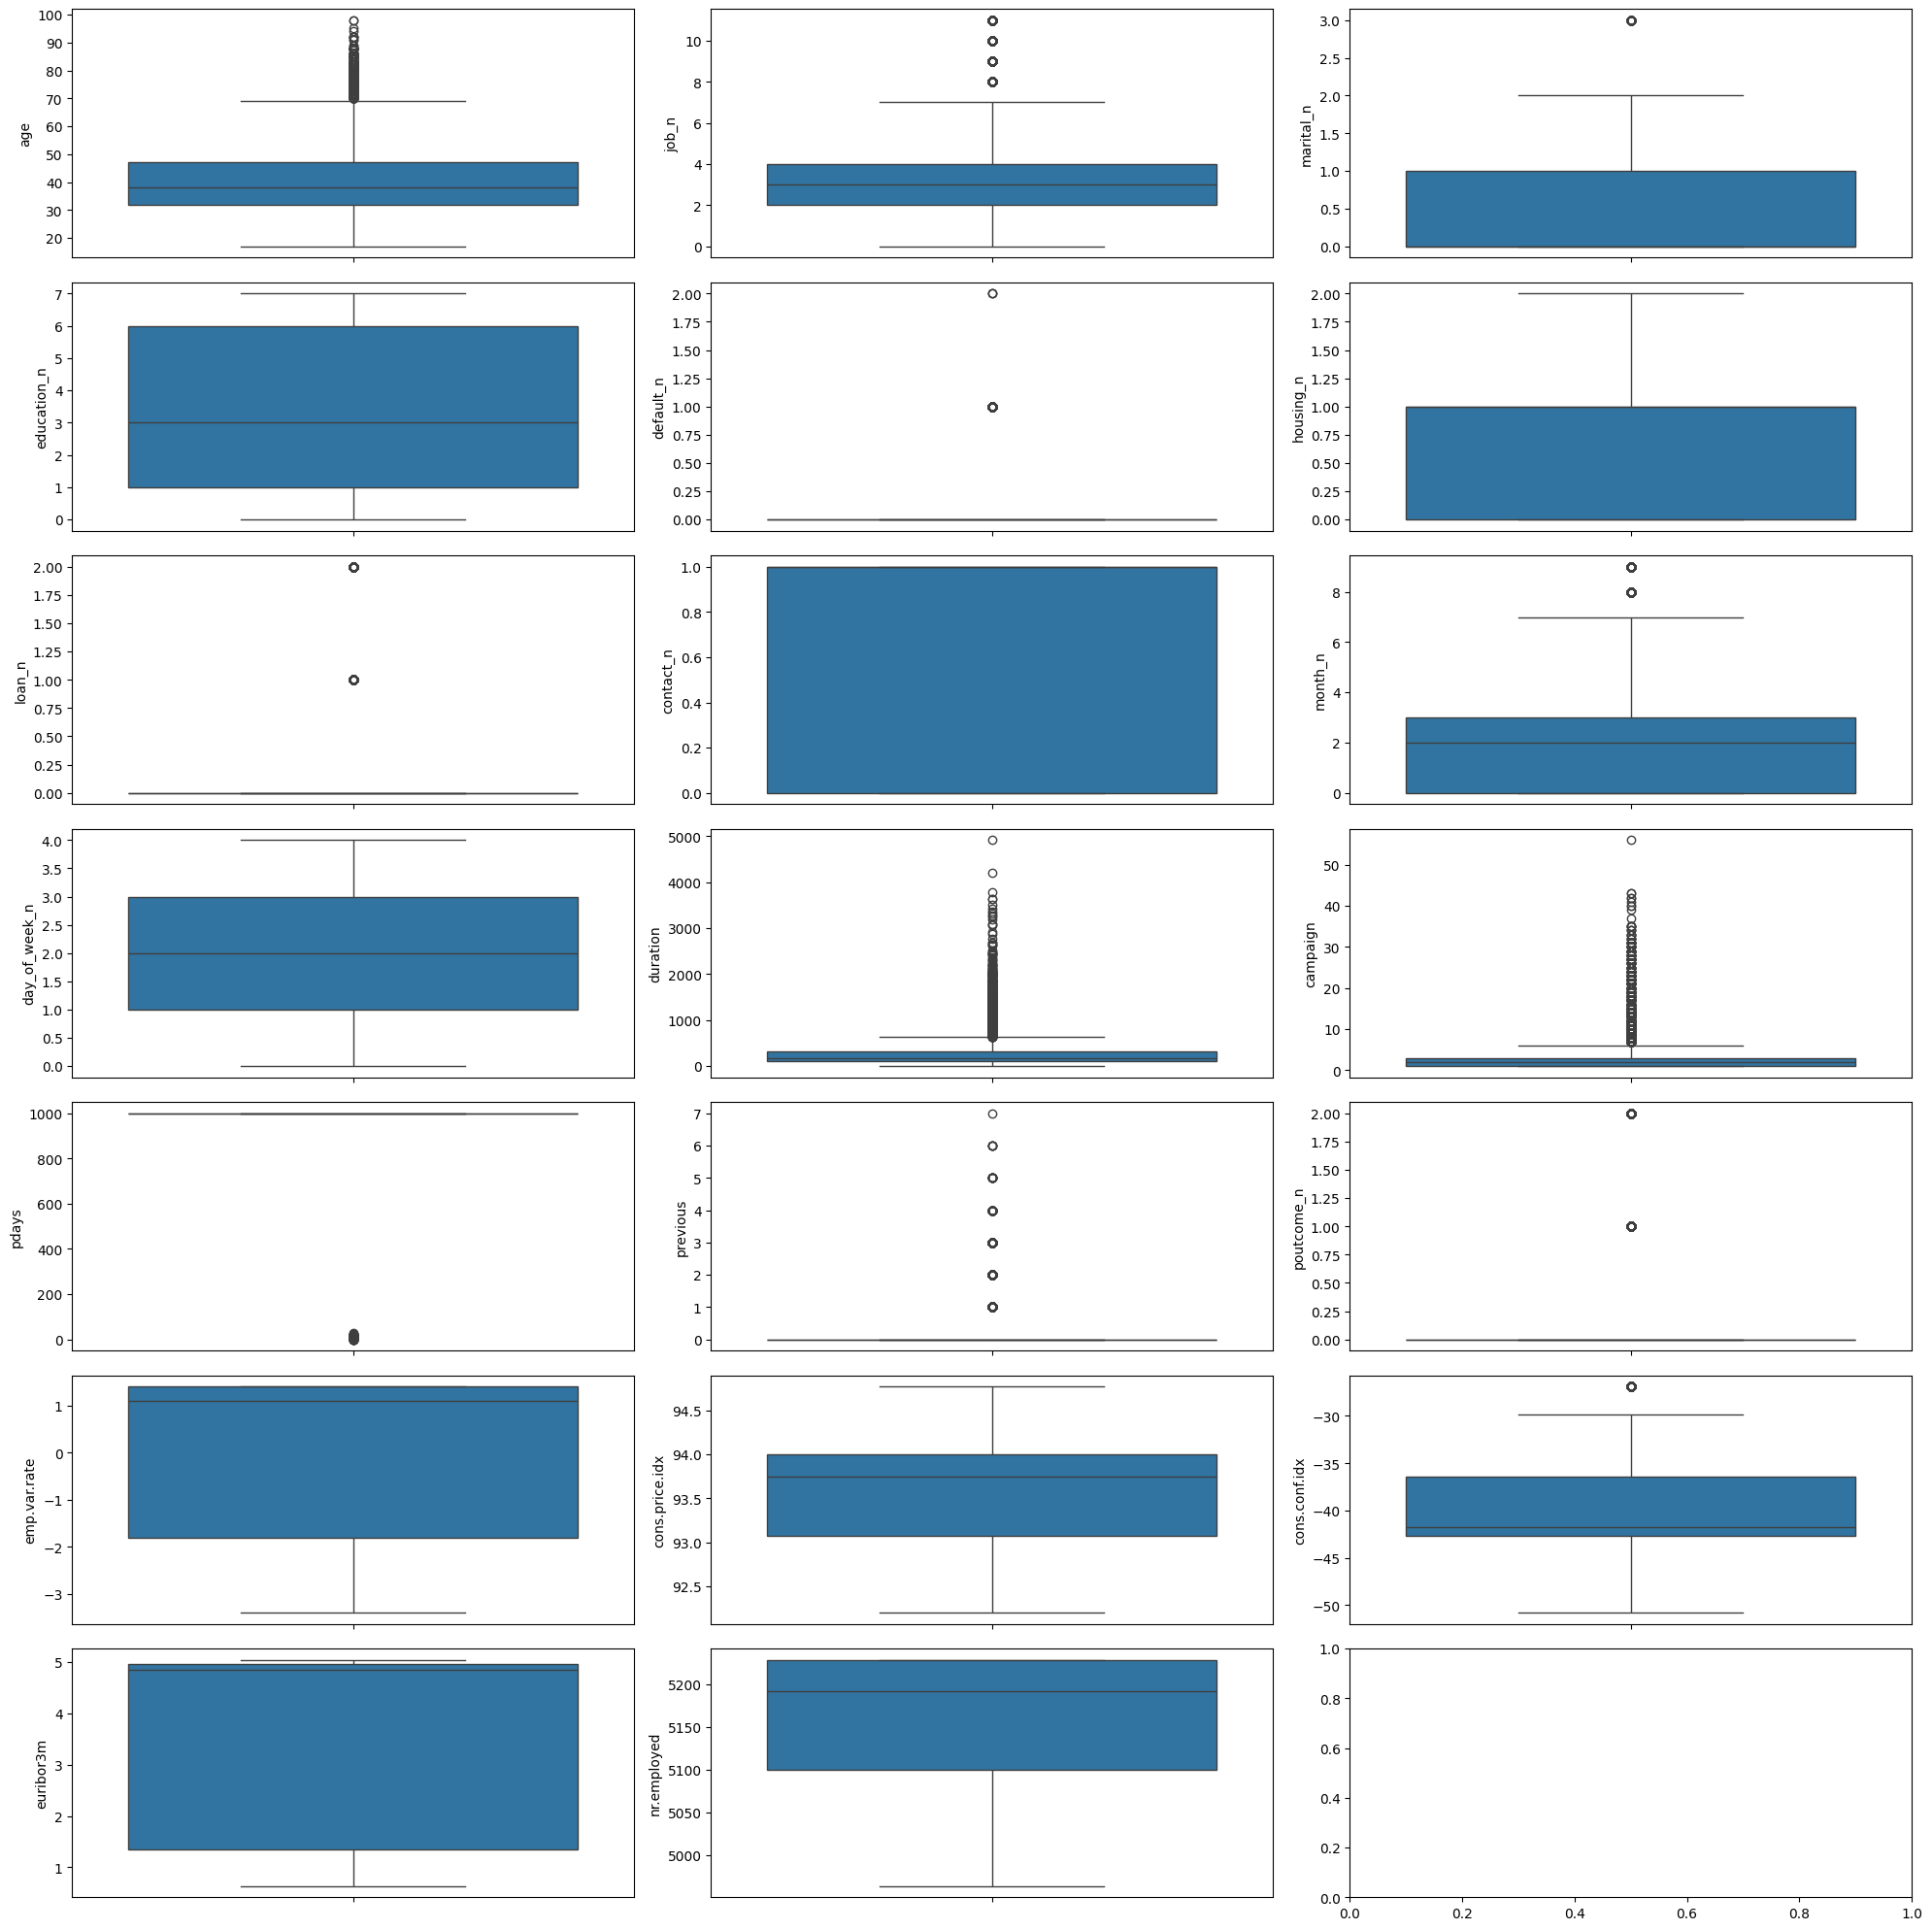

In [ ]:
fig, axis = plt.subplots(7, 3, figsize=(20, 20))

sns.boxplot(ax=axis[0, 0], data=raw_data, y="age")
sns.boxplot(ax=axis[0, 1], data=raw_data, y="job_n")
sns.boxplot(ax=axis[0, 2], data=raw_data, y="marital_n")
sns.boxplot(ax=axis[1, 0], data=raw_data, y="education_n")
sns.boxplot(ax=axis[1, 1], data=raw_data, y="default_n")
sns.boxplot(ax=axis[1, 2], data=raw_data, y="housing_n")
sns.boxplot(ax=axis[2, 0], data=raw_data, y="loan_n")
sns.boxplot(ax=axis[2, 1], data=raw_data, y="contact_n")
sns.boxplot(ax=axis[2, 2], data=raw_data, y="month_n")
sns.boxplot(ax=axis[3, 0], data=raw_data, y="day_of_week_n")
sns.boxplot(ax=axis[3, 1], data=raw_data, y="duration")
sns.boxplot(ax=axis[3, 2], data=raw_data, y="campaign")
sns.boxplot(ax=axis[4, 0], data=raw_data, y="pdays")
sns.boxplot(ax=axis[4, 1], data=raw_data, y="previous")
sns.boxplot(ax=axis[4, 2], data=raw_data, y="poutcome_n")
sns.boxplot(ax=axis[5, 0], data=raw_data, y="emp.var.rate")
sns.boxplot(ax=axis[5, 1], data=raw_data, y="cons.price.idx")
sns.boxplot(ax=axis[5, 2], data=raw_data, y="cons.conf.idx")
sns.boxplot(ax=axis[6, 0], data=raw_data, y="euribor3m")
sns.boxplot(ax=axis[6, 1], data=raw_data, y="nr.employed")

plt.tight_layout()

plt.show()

Items affected by outliers: age, job type, marital status, whether prospect is in default or has a personal loan, last month in which they've been contacted, length of call if over 500 seconds long, number of contacts in prior campaign (anything > around 5 is shown as an outlier), Number of days since alst contact, and consumer confidence index.

Maintain-eliminate-replace decisions: Age has enough data points listed in outliers that I wonder whether a separate analysis could be run for lower-aged vs. retiree-aged prospects.  Marital status outlier corresponds to divorcees, but this seems common enough (roughly 11%) that I'd keep it.  Consumer confidence index outlier seems isolated enough to drop.  Number of days since last contact has a clustered bit marked as an outlier but I remember that being charted as one of the most-relevant-seeming variables, so I wonder whether that cluster's important to keep.  Poutcome charted circles for "outliers" actually seem like the success/failure indicators we need as data to learn from, so am wondering whether I should've already separated out the "nonexistent" outcomes earlier in data cleaning (i.e. is nonexistint a synonym for Null / NaN or does it indicate a prospect has neither requeted nor rejected offers for services yet?)

In [ ]:
print(raw_data["cons.conf.idx"].describe())
outlier_threshold = -30  # picked approximately 80th percentile
atypical_cons_conf_idx = raw_data.query("`cons.conf.idx` > @outlier_threshold")
print(atypical_cons_conf_idx)
raw_data = raw_data.query(
    f"`cons.conf.idx` <= {outlier_threshold}"
)  # to drop the outlier rows

count    41176.000000
mean       -40.502863
std          4.627860
min        -50.800000
25%        -42.700000
50%        -41.800000
75%        -36.400000
max        -26.900000
Name: cons.conf.idx, dtype: float64
       age           job   marital          education  default housing loan  \
37887   53        admin.   married  university.degree  unknown     yes   no   
37888   32        admin.    single  university.degree       no     yes  yes   
37889   52        admin.   married            unknown       no      no   no   
37890   39  entrepreneur   married           basic.6y       no     yes   no   
37891   32        admin.    single  university.degree       no     yes   no   
...    ...           ...       ...                ...      ...     ...  ...   
38596   69       retired   married           basic.4y       no     yes  yes   
38597   18       student    single           basic.6y       no      no  yes   
38598   59       retired  divorced           basic.4y       no     yes   no  

In [ ]:
print(raw_data["campaign"].describe())
outlier_threshold = 50
atypical_campaign_value = raw_data.query(f"campaign > {outlier_threshold}")
print(atypical_campaign_value)
raw_data = raw_data.query(
    f"campaign <= {outlier_threshold}"
)  # to drop the outlier rows

count    40463.000000
mean         2.585275
std          2.788171
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         56.000000
Name: campaign, dtype: float64
      age     job  marital          education  default  housing     loan  \
4107   32  admin.  married  university.degree  unknown  unknown  unknown   

        contact month day_of_week  ...  job_n  marital_n  education_n  \
4107  telephone   may         mon  ...      2          0            6   

      default_n housing_n  loan_n  contact_n  month_n  day_of_week_n  \
4107          1         2       2          0        0              0   

      poutcome_n  
4107           0  

[1 rows x 31 columns]


In [ ]:
print(raw_data["duration"].describe())
outlier_threshold = 4000
atypical_duration = raw_data.query(f"duration > {outlier_threshold}")
print(atypical_duration)
raw_data = raw_data.query(
    f"duration <= {outlier_threshold}"
)  # to drop the outlier rows

count    40462.000000
mean       257.923558
std        259.102564
min          0.000000
25%        102.000000
50%        179.000000
75%        319.000000
max       4918.000000
Name: duration, dtype: float64
       age          job  marital            education default housing loan  \
22192   52  blue-collar  married             basic.4y      no      no   no   
24091   33   technician   single  professional.course      no     yes   no   

         contact month day_of_week  ...  job_n  marital_n  education_n  \
22192  telephone   aug         thu  ...      3          0            0   
24091  telephone   nov         mon  ...      4          1            4   

       default_n housing_n  loan_n  contact_n  month_n  day_of_week_n  \
22192          0         0       0          0        3              3   
24091          0         1       0          0        5              0   

       poutcome_n  
22192           0  
24091           0  

[2 rows x 31 columns]


### Building logistic regression model

#### Feature scaling
##### Splitting training vs test data

In [ ]:
from sklearn.model_selection import train_test_split

num_variables = [
    "age",
    "job_n",
    "marital_n",
    "education_n",
    "default_n",
    "housing_n",
    "loan_n",
    "contact_n",
    "month_n",
    "day_of_week_n",
    "duration",
    "campaign",
    "pdays",
    "previous",
    "emp.var.rate",
    "cons.price.idx",
    "cons.conf.idx",
    "euribor3m",
    "nr.employed",
]


# We divide the dataset into training and test samples
X = raw_data.drop("poutcome_n", axis=1)[num_variables]
y = raw_data["poutcome_n"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train.head()

,age,job_n,marital_n,education_n,default_n,housing_n,loan_n,contact_n,month_n,day_of_week_n,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
32140,38,2,0,1,0,1,0,1,0,4,213,5,999,0,-1.8,92.893,-46.2,1.313,5099.1
38791,66,5,0,0,0,1,1,0,5,3,1127,1,999,0,-3.4,92.649,-30.1,0.714,5017.5
29839,34,2,0,3,0,1,0,1,8,0,401,2,999,0,-1.8,93.075,-47.1,1.405,5099.1
6201,50,1,0,2,0,0,0,0,0,1,377,1,999,0,1.1,93.994,-36.4,4.857,5191.0
25293,41,4,1,4,1,1,0,1,5,1,68,2,4,1,-0.1,93.200,-42.0,4.153,5195.8


In [ ]:
# normalization scaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

X_train_norm = scaler.transform(X_train)
X_train_norm = pd.DataFrame(X_train_norm, index=X_train.index, columns=num_variables)

X_test_norm = scaler.transform(X_test)
X_test_norm = pd.DataFrame(X_test_norm, index=X_test.index, columns=num_variables)

X_train_norm.head()

,age,job_n,marital_n,education_n,default_n,housing_n,loan_n,contact_n,month_n,day_of_week_n,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
32140,-0.184978,-0.679144,-0.738824,-1.043982,-0.516863,0.796144,-0.439289,0.763253,-0.922330,1.432698,-0.173323,0.868251,0.187119,-0.340099,-1.287543,-1.252000,-1.257623,-1.385809,-1.009614
38791,2.551921,0.549525,-0.738824,-1.502403,-0.516863,0.796144,1.762802,-1.310182,1.176781,0.725655,3.401828,-0.569087,0.187119,-0.340099,-2.345618,-1.686068,2.441139,-1.737106,-2.173948
29839,-0.575963,-0.679144,-0.738824,-0.127139,-0.516863,0.796144,-0.439289,0.763253,2.436248,-1.395476,0.562048,-0.209752,0.187119,-0.340099,-1.287543,-0.928228,-1.464386,-1.331854,-1.009614
6201,0.987979,-1.088700,-0.738824,-0.585561,-0.516863,-1.055652,-0.439289,-1.310182,-0.922330,-0.688433,0.468171,-0.569087,0.187119,-0.340099,0.630218,0.706643,0.993798,0.692650,0.301688
25293,0.108261,0.139969,0.689831,0.331282,1.933315,0.796144,-0.439289,0.763253,1.176781,-0.688433,-0.740496,-0.209752,-5.355859,1.701126,-0.163338,-0.705857,-0.292728,0.279773,0.370178


In [ ]:
# min-max scaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train)

X_train_scal = scaler.transform(X_train)
X_train_scal = pd.DataFrame(X_train_scal, index=X_train.index, columns=num_variables)

X_test_scal = scaler.transform(X_test)
X_test_scal = pd.DataFrame(X_test_scal, index=X_test.index, columns=num_variables)

X_train_scal.head()

,age,job_n,marital_n,education_n,default_n,housing_n,loan_n,contact_n,month_n,day_of_week_n,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
32140,0.269231,0.181818,0.000000,0.142857,0.0,0.5,0.0,1.0,0.000000,1.00,0.056275,0.095238,1.000000,0.000000,0.333333,0.269680,0.222222,0.153933,0.512287
38791,0.628205,0.454545,0.000000,0.000000,0.0,0.5,0.5,0.0,0.555556,0.75,0.297754,0.000000,1.000000,0.000000,0.000000,0.174591,1.000000,0.018136,0.203781
29839,0.217949,0.181818,0.000000,0.428571,0.0,0.5,0.0,1.0,0.888889,0.00,0.105945,0.023810,1.000000,0.000000,0.333333,0.340608,0.178744,0.174790,0.512287
6201,0.423077,0.090909,0.000000,0.285714,0.0,0.0,0.0,0.0,0.000000,0.25,0.099604,0.000000,1.000000,0.000000,0.937500,0.698753,0.695652,0.957379,0.859735
25293,0.307692,0.363636,0.333333,0.571429,0.5,0.5,0.0,1.0,0.555556,0.25,0.017966,0.023810,0.004004,0.142857,0.687500,0.389322,0.425121,0.797778,0.877883


In [ ]:
# feature selection for selecting most-relevant features to use for building ML model

from sklearn.feature_selection import f_classif, SelectKBest

# With a value of k = 16 we implicitly mean that we want to remove 4 features from the 20-column dataset
selection_model = SelectKBest(f_classif, k=16)
selection_model.fit(X_train_scal, y_train)
ix = selection_model.get_support()
X_train_sel = pd.DataFrame(
    selection_model.transform(X_train), columns=X_train.columns.values[ix]
)
X_test_sel = pd.DataFrame(
    selection_model.transform(X_test), columns=X_test.columns.values[ix]
)

X_train_sel.head()

,age,job_n,marital_n,education_n,default_n,contact_n,month_n,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,38.0,2.0,0.0,1.0,0.0,1.0,0.0,213.0,5.0,999.0,0.0,-1.8,92.893,-46.2,1.313,5099.1
1,66.0,5.0,0.0,0.0,0.0,0.0,5.0,1127.0,1.0,999.0,0.0,-3.4,92.649,-30.1,0.714,5017.5
2,34.0,2.0,0.0,3.0,0.0,1.0,8.0,401.0,2.0,999.0,0.0,-1.8,93.075,-47.1,1.405,5099.1
3,50.0,1.0,0.0,2.0,0.0,0.0,0.0,377.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0
4,41.0,4.0,1.0,4.0,1.0,1.0,5.0,68.0,2.0,4.0,1.0,-0.1,93.200,-42.0,4.153,5195.8


In [ ]:
X_train_sel["poutcome_n"] = list(y_train)
X_test_sel["poutcome_n"] = list(y_test)

In [ ]:
X_train_sel.to_csv(
    "../data/interim/clean_banking_marketing_campaign.csv",
    index=False,
)
X_test_sel.to_csv("../data/interim/clean_banking_marketing_campaign.csv", index=False)

In [ ]:
import pandas as pd

train_data = pd.read_csv("../data/interim/clean_banking_marketing_campaign.csv")
test_data = pd.read_csv("../data/interim/clean_banking_marketing_campaign.csv")

train_data.head()

,age,job_n,marital_n,education_n,default_n,contact_n,month_n,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,price,poutcome_n
0,50.0,3.0,0.0,0.0,0.0,1.0,0.0,197.0,2.0,999.0,0.0,-1.8,92.893,-46.2,1.299,5099.1,0,0
1,30.0,6.0,1.0,1.0,0.0,1.0,0.0,402.0,2.0,999.0,0.0,-1.8,92.893,-46.2,1.334,5099.1,0,0
2,50.0,3.0,0.0,0.0,1.0,0.0,0.0,100.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.856,5191.0,0,0
3,59.0,1.0,0.0,1.0,0.0,1.0,8.0,542.0,3.0,999.0,1.0,-1.8,93.075,-47.1,1.453,5099.1,1,1
4,41.0,4.0,0.0,4.0,0.0,1.0,8.0,466.0,5.0,999.0,1.0,-1.8,93.075,-47.1,1.423,5099.1,1,1


In [ ]:
X_train = train_data.drop(["poutcome_n"], axis=1)
y_train = train_data["poutcome_n"]
X_test = test_data.drop(["poutcome_n"], axis=1)
y_test = test_data["poutcome_n"]

In [ ]:
from sklearn.linear_model import LogisticRegression

model_using_plain_default_hyperparams = LogisticRegression()
model_using_plain_default_hyperparams.fit(X_train, y_train)

c:\Users\Nick\git\logistic-regression-project-tutorial-NWinocur\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:
y_pred = model_using_plain_default_hyperparams.predict(X_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0], shape=(8092,))

#### Accuracy score without hyperparameter optimization

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred)

0.8947108255066732

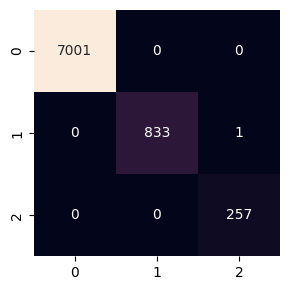

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

bank_marketing_co_matr = confusion_matrix(y_test, y_pred)

# Let's draw this matrix to make it more visual
cm_df = pd.DataFrame(bank_marketing_co_matr)

plt.figure(figsize=(3, 3))
sns.heatmap(cm_df, annot=True, fmt="d", cbar=False)

plt.tight_layout()

plt.show()

In [ ]:
model_using_higher_max_iterations = LogisticRegression(max_iter=100000)
model_using_higher_max_iterations.fit(X_train, y_train)
y_pred = model_using_higher_max_iterations.predict(X_test)
y_pred
accuracy_score(y_test, y_pred)

0.999876421156698

Three-nines accuracy in less than 25 seconds of processing time made this better in terms of both accuracy and computational intensity vs. just jumping straight to trying hyperparameter tuning on an otherwise-default model.

#### Hyperparameter optimizing
##### Grid search

In [ ]:
from sklearn.model_selection import GridSearchCV

# We define the parameters that we want to adjust by hand
hyperparams = {
    "C": [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    "penalty": ["l1", "l2", "elasticnet", None],
    "solver": ["newton-cg", "lbfgs", "liblinear", "sag", "saga"],
}

# We initialize the grid
grid = GridSearchCV(
    model_using_plain_default_hyperparams, hyperparams, scoring="accuracy", cv=5
)
grid

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'penalty': ['l1', 'l2', 'elasticnet', None],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             scoring='accuracy')

In [ ]:
def warn(*args, **kwargs):
    pass


import warnings

warnings.warn = warn

grid.fit(X_train, y_train)

print(f"Best hyperparameters: {grid.best_params_}")

Best hyperparameters: {'C': 0.001, 'penalty': None, 'solver': 'newton-cg'}


In [ ]:
model_grid = LogisticRegression(penalty="l1", C=10, solver="liblinear")
model_grid.fit(X_train, y_train)
y_pred = model_grid.predict(X_test)

grid_accuracy = accuracy_score(y_test, y_pred)
grid_accuracy

0.9962926347009392

Two-nines accuracy is substantially better than sub-90, and is better than random search finds in cells below.  But needing to take about 3 minutes 43 seconds to get it seems not worthwhile to me vs. just upping the max iterations on the plain model enough to get three nines in less time.

##### Random search hyperparameter optimization-hunting

In [ ]:
import numpy as np
from sklearn.model_selection import RandomizedSearchCV

# We define the parameters we want to adjust
hyperparams = {
    "C": np.logspace(-4, 4, 20),
    "penalty": ["l1", "l2", "elasticnet", None],
    "solver": ["newton-cg", "lbfgs", "liblinear", "sag", "saga"],
}

# We initialize the random search
random_search = RandomizedSearchCV(
    model_using_plain_default_hyperparams,
    hyperparams,
    n_iter=100,
    scoring="accuracy",
    cv=5,
    random_state=42,
)
random_search

RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_iter=100,
                   param_distributions={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                                        'penalty': ['l1', 'l2', 'elasticnet',
                                                    None],
                                        'solver': ['newton-cg', 'lbfgs',
                                                   'liblinear', 'sag',
                                                   'saga']},
                   random_state=42, scoring='accuracy')

In [ ]:
random_search.fit(X_train, y_train)

print(f"Best hyperparameters: {random_search.best_params_}")

c:\Users\Nick\git\logistic-regression-project-tutorial-NWinocur\.venv\Lib\site-packages\scipy\optimize\_linesearch.py:312: LineSearchWarning: The line search algorithm did not converge
  alpha_star, phi_star, old_fval, derphi_star = scalar_search_wolfe2(
c:\Users\Nick\git\logistic-regression-project-tutorial-NWinocur\.venv\Lib\site-packages\sklearn\utils\optimize.py:100: LineSearchWarning: The line search algorithm did not converge
  ret = line_search_wolfe2(


Best hyperparameters: {'solver': 'newton-cg', 'penalty': 'l2', 'C': np.float64(10000.0)}


In [ ]:
model_random_search = LogisticRegression(penalty="l2", C=29.7635, solver="lbfgs")
model_random_search.fit(X_train, y_train)
y_pred = model_random_search.predict(X_test)

random_search_accuracy = accuracy_score(y_test, y_pred)
random_search_accuracy

0.8952051408798813

89.52% accuracy is better than 89.47%, barely, but still not as good as either upping max iteration on an otherwise-default model, or the hyperparameters found by grid search above.